# Constant Acceleration and Noise

Generate 2d kinematic data with constant acceleration and noise. Adds noise to each measurement

In [82]:
using Plots
function generateKinematics(ax,ay,x0,y0,vx0,vy0,dt,measurements,noise,vnoise)
    #Measurement Arrays
    x = [x0]
    y = [y0]
    vx = [vx0]
    vy = [vy0]

    #Generate true gold set data based on kinematic equations 
    for i in 2:measurements
        ax *= 1.01
        xi = x[i-1] + vx[i-1] * dt + ax * .5 * dt^2
        yi = y[i-1] + vy[i-1] * dt + ay * .5 * dt^2
        vxi = vx[i-1] + ax*dt
        vyi = vy[i-1] + ay*dt
        append!(x,xi)
        append!(y,yi)
        append!(vx,vxi)
        append!(vy,vyi)
    end

    #Plot true data
    #plot(x,y, label="True")

    #Add and plot noise
    xn = x + (rand(Float64,size(x)) .* noise .- noise/2)
    yn = y + (rand(Float64,size(y)) .* noise .- noise/2)
    vxn = vx + (rand(Float64,size(vx)) .* vnoise .- vnoise/2)
    vyn = vy + (rand(Float64,size(vy)) .* vnoise .- vnoise/2)
    measurements = hcat(xn,yn,vxn,vyn)
    measurementsTrue = hcat(x,y,vx,vy)
    #scatter!(xn,yn,label="Measured")
    return measurements, measurementsTrue
end

noise = 30
vnoise = 2
dt = 1
measurements = 100
#ax,ay,x,y,vx,vy
m1,m1T = generateKinematics( .1 , .1  ,0.0   ,60.0  ,0.0, 0.0,dt,measurements,noise,vnoise)
m2,m2T = generateKinematics(-.1 , .1  ,400.0 ,400.0,0.0, 0.0,dt,measurements,noise,vnoise)
m3,m3T = generateKinematics( .05, .05 ,20.0  ,30.0 ,0.0, 0.0,dt,measurements,noise,vnoise)
m4,m4T = generateKinematics(  0 , .1  ,333   ,0.0  ,0.0, 0.0,dt,measurements,noise,vnoise)
measurementsNoise = permutedims(cat(m1,m2,m3,m4,dims=3),[2,3,1])
measurementsTrue = permutedims(cat(m1T,m2T,m3T,m4T,dims=3),[2,3,1])

4×4×100 Array{Float64,3}:
[:, :, 1] =
  0.0  400.0  20.0  333.0
 60.0  400.0  30.0    0.0
  0.0    0.0   0.0    0.0
  0.0    0.0   0.0    0.0

[:, :, 2] =
  0.0505  399.95   20.0252  333.0 
 60.05    400.05   30.025     0.05
  0.101    -0.101   0.0505    0.0 
  0.1       0.1     0.05      0.1 

[:, :, 3] =
  0.202505  399.797    20.1013    333.0
 60.2       400.2      30.1         0.2
  0.20301    -0.20301   0.101505    0.0
  0.2         0.2       0.1         0.2

...

[:, :, 98] =
 670.026   -270.026   355.013    333.0 
 530.45     870.45    265.225    470.45
  16.4152   -16.4152    8.20759    0.0 
   9.7        9.7       4.85       9.7 

[:, :, 99] =
 686.574   -286.574   363.287    333.0
 540.2      880.2     270.1      480.2
  16.6803   -16.6803    8.34017    0.0
   9.8        9.8       4.9        9.8

[:, :, 100] =
 703.388   -303.388   371.694    333.0 
 550.05     890.05    275.025    490.05
  16.9481   -16.9481    8.47407    0.0 
   9.9        9.9       4.95       9.9 

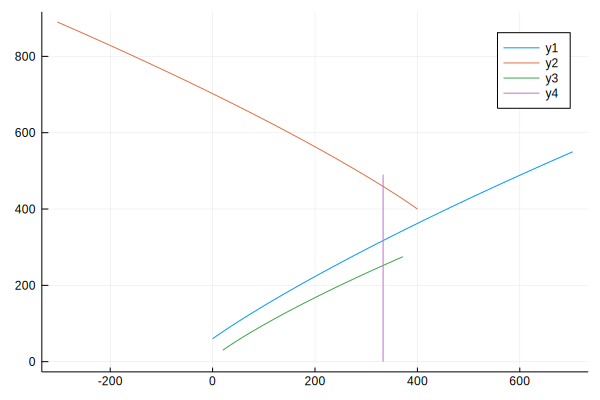

In [83]:
plot(measurementsTrue[1,1,:],measurementsTrue[2,1,:])
plot!(measurementsTrue[1,2,:],measurementsTrue[2,2,:])
plot!(measurementsTrue[1,3,:],measurementsTrue[2,3,:])
plot!(measurementsTrue[1,4,:],measurementsTrue[2,4,:])

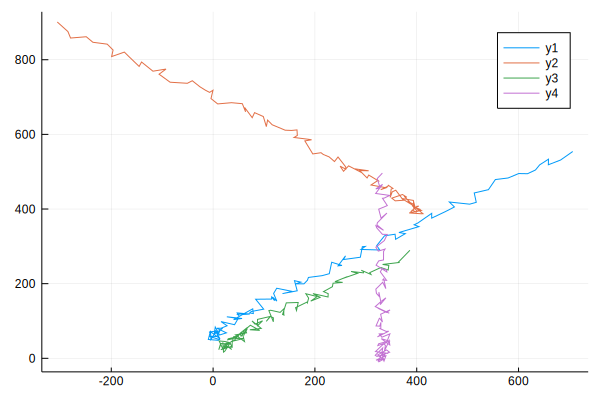

In [84]:
plot(measurementsNoise[1,1,:],measurementsNoise[2,1,:])
plot!(measurementsNoise[1,2,:],measurementsNoise[2,2,:])
plot!(measurementsNoise[1,3,:],measurementsNoise[2,3,:])
plot!(measurementsNoise[1,4,:],measurementsNoise[2,4,:])

In [85]:
file = open("data/measurements.hpp","w+")
print(size(measurementsNoise))
write(file, "float measurements[100][16] = {")
write(file, replace(replace(replace(replace(string(permutedims(measurementsNoise,(2,1,3))) , "[" => "{"),"]"=>"},")," "=>", "),";,"=>",")[1:end-1])  
write(file, "};\n")

close(file)

(4, 4, 100)

Kalman Filter Functions

In [86]:
using LinearAlgebra
function predict(A,X,B,U,P,Q)
    Xp = A*X + B.*U
    Pp = A *P*transpose(A) + Q
    return Xp,Pp
end

function update(P,H,R,Xp,Y)
    Ht = transpose(H)
    K= (P*Ht) * inv(H*P*Ht+R)
    Xk = Xp + K* (Y-H*Xp)
    Pk = (I - K*H)*P
    return Xk,Pk,K
end 

update (generic function with 1 method)

Runs the Kalman Filter on kinematic data. State transition models based off kinematic equations. 
Non diagonal Covariance terms not used for simplicity.

In [87]:
function runKalmanKinematic(measurements,dt,ax1,ay1,ax2,ay2,ax3,ay3,ax4,ay4,noise,vnoise)
    #Set up initial state
    X = measurements[:,:,1]
    xpred = [X]
    kalmanGains = []
    
    #State transisition matrix, adds dt*velocity to position
    A = [1 0 dt 0; 0 1 0 dt; 0 0 1 0; 0 0 0 1]
    
    #Control matrix, updates position and velocity based on acceleration
    B = [.5*dt^2;.5*dt^2;dt;dt] 
    U = [ax1 ax2 ax3 ax4;ay1 ay2 ay3 ay4;ax1 ax2 ax3 ax4;ay1 ay2 ay3 ay4]
    H = I
    R = [noise^2 0 0 0;
         0 noise^2 0 0;
         0 0 vnoise^2 0;
         0 0 0 vnoise^2]
    Q = I 
    P = Q
    for i in 2:(size(measurements)[3])
        Xp, Pp = predict(A,X,B,U,P,Q)
        Xk, Pk, K = update(Pp,H,R,Xp,measurements[:,:,i])
        append!(xpred,[Xk])
        append!(kalmanGains,[diag(K)])
        P = Pk
        X = Xk
        display(X)
    end
    
    return cat(xpred...,dims=3),hcat(kalmanGains...)
end

runKalmanKinematic (generic function with 1 method)

Kalman Filter is run on measurements, green line is filtered value and blue line is the true value

4×4 Array{Float64,2}:
 10.6976     400.935      19.1814    338.137   
 48.2288     394.059      43.045       8.70963 
  0.0234236   -0.190001   -0.160471   -0.425174
 -0.170205     0.0730689   0.584144   -0.490127

4×4 Array{Float64,2}:
 10.8369    401.267     19.3594    337.652   
 48.8142    393.971     43.2305      7.92581 
  0.748169    0.313052   0.292222   -0.457179
  0.300445    0.029165   0.70288    -0.639743

4×4 Array{Float64,2}:
 11.0184    401.709       19.8785     336.847    
 49.122     393.796       43.5211       7.29514  
  0.534924    0.161781     0.0115881   -0.260031 
  0.286651    0.00980276   0.0607208   -0.0503614

4×4 Array{Float64,2}:
 10.9945     400.958     20.5069    337.074   
 50.156      393.493     43.1105      7.69355 
 -0.0881237   -0.426742   0.361284    0.400878
  0.178775    -0.25099   -0.452262    0.767097

4×4 Array{Float64,2}:
 10.483       400.7       20.3189    336.955   
 51.0433      393.488     42.8921      7.73544 
  0.551102     -0.755805  -0.195196   -0.367604
 -0.00428981   -0.020224   0.193818    0.675725

4×4 Array{Float64,2}:
 10.4131    399.25       19.9272     336.502   
 52.3982    394.118      42.0564       7.76569 
  0.647701   -1.28214     0.217295    -0.319022
  0.865948   -0.0303208   0.0830395    0.498859

4×4 Array{Float64,2}:
 11.3617    398.927     19.6016    335.524   
 53.3385    394.597     41.8554      7.48443 
  0.952345   -0.385273  -0.231939   -0.51879 
  1.09624     0.386402  -0.191443    0.766619

4×4 Array{Float64,2}:
 11.4121    398.317      19.8979     334.681   
 55.6167    394.598      41.6234       8.03911 
  0.335706   -0.818513    0.481822    -0.185125
  0.981426    0.0883352   0.0677731    1.22282 

4×4 Array{Float64,2}:
 11.6858    397.289     20.9813    334.117   
 57.2451    395.021     41.2692      7.90722 
  0.649513   -0.533986   0.779713    0.297993
  0.641956    0.395125   0.331147    0.85343 

4×4 Array{Float64,2}:
 12.3483    396.294     22.8448    334.148    
 57.6688    395.092     40.1395      9.09018  
  0.638276   -0.314188   0.959764   -0.0964864
  1.20213     0.308084  -0.13216     0.416212 

4×4 Array{Float64,2}:
 11.8032   395.791     23.8564    333.736   
 58.8563   396.237     39.8261      8.61408 
  1.2034    -1.23039    0.396749   -0.499153
  1.12098    0.337363   0.500081    0.353371

4×4 Array{Float64,2}:
 12.3968    395.101    23.8959    332.672  
 59.75      397.672    39.1967      9.5545 
  0.824695   -1.52252   0.94279    -0.24093
  0.944154    0.84958   0.718353    1.41753

4×4 Array{Float64,2}:
 13.2634    393.737    25.7459    332.835   
 61.7741    399.168    39.1471     11.7662  
  0.755568   -1.30243   0.940228   -0.650507
  0.775449    1.50403   0.365668    1.30891 

4×4 Array{Float64,2}:
 14.4924    392.758     27.2632    333.315   
 64.1242    402.387     39.8233     13.3544  
  0.948211   -0.900783   1.24103    -0.619392
  1.11537     1.85483    0.547766    1.3836  

4×4 Array{Float64,2}:
 14.5976   391.73     27.698     332.147  
 65.3679   404.301    40.8092     13.8722 
  1.3465    -1.80138   0.578355   -0.57197
  1.48024    1.55333   0.667239    1.05195

4×4 Array{Float64,2}:
 15.2029   390.124    27.2463    332.442    
 68.5789   406.173    41.654      14.5661   
  1.72816   -2.24903   1.11927     0.0508349
  2.18224    1.93556   0.262472    1.15645  

4×4 Array{Float64,2}:
 16.7729   386.449    27.4762    331.648    
 69.6828   409.472    40.2357     15.147    
  2.09737   -2.27085   0.717943    0.0990511
  1.45558    1.41506   0.102104    1.70184  

4×4 Array{Float64,2}:
 19.2134   384.921    28.2981   330.934   
 70.9662   412.069    40.9245    16.1697  
  1.63934   -2.32467   1.2979     0.626081
  1.59735    1.7563    1.15859    1.78996 

4×4 Array{Float64,2}:
 19.6453   383.61     29.9973    331.644  
 73.3582   413.553    41.6129     19.0198 
  1.48521   -2.38173   1.24354     0.52846
  1.85153    1.56735   0.503337    2.24501

4×4 Array{Float64,2}:
 20.9622   381.339    30.0579    331.859    
 76.0516   415.614    41.6265     20.8661   
  2.03716   -2.32775   0.843807    0.0253633
  2.58453    1.61488   1.12966     2.36198  

4×4 Array{Float64,2}:
 23.6644   379.551    31.4722    333.004   
 78.9392   417.115    41.878      22.2174  
  2.58581   -2.96506   0.876948    0.196541
  1.80939    1.89891   1.59236     2.11726 

4×4 Array{Float64,2}:
 25.5446   376.656    32.9412   332.179   
 82.7054   420.205    43.0194    24.0569  
  2.98347   -2.63278   1.17824    0.548002
  2.67083    1.68471   1.00842    2.61266 

4×4 Array{Float64,2}:
 29.4336   374.419    34.458     332.711   
 85.8743   422.853    45.3858     27.9277  
  2.49194   -2.96135   0.803858    0.184539
  2.87112    1.94977   1.30535     3.08185 

4×4 Array{Float64,2}:
 33.2149   371.272    37.0533   333.141   
 88.9259   425.976    47.8833    31.2168  
  3.17596   -3.41921   1.7192    -0.257762
  2.76154    1.89338   1.59163    2.83749 

4×4 Array{Float64,2}:
 37.1874   366.845    38.2182   333.099   
 91.5235   428.014    49.6305    32.937   
  3.52902   -2.59309   2.14915   -0.466997
  2.22017    1.97768   1.42499    3.01204 

4×4 Array{Float64,2}:
 40.9764   363.251    38.832    333.945   
 94.6947   429.411    50.8346    37.0262  
  2.65833   -3.42995   1.16895   -0.181818
  1.93096    2.21332   1.24743    3.20814 

4×4 Array{Float64,2}:
 42.3015   360.996    39.634     334.788   
 98.1563   431.03     52.1725     39.7599  
  2.88115   -3.51746   0.807867   -0.424987
  2.42915    2.43683   1.41328     3.04969 

4×4 Array{Float64,2}:
  46.4207   357.645    41.7854   334.421   
 101.012    434.878    54.2489    43.4333  
   3.30627   -3.43219   1.49813    0.334255
   2.24124    2.32887   0.88372    2.64019 

4×4 Array{Float64,2}:
  48.8509   354.03     43.2502   335.456    
 103.216    438.226    54.9521    46.3288   
   3.20869   -3.40038   1.73164   -0.0942119
   2.10413    2.83319   1.74425    3.08025  

4×4 Array{Float64,2}:
  52.9373   350.593    43.8988   334.817  
 106.727    439.953    55.4283    48.6295 
   3.43783   -3.02571   1.43901    0.5495 
   2.4236     2.40354   1.35267    3.33686

4×4 Array{Float64,2}:
  55.789    347.276    46.9497   334.411   
 110.34     443.683    56.5826    50.0717  
   3.7608    -3.94786   1.92224    0.680795
   3.25073    3.11595   1.55081    2.71829 

4×4 Array{Float64,2}:
  58.9813   344.571    48.619    335.302   
 113.386    447.825    57.8251    52.3151  
   4.0996    -3.26185   2.40496    0.149808
   2.77963    3.67536   1.79057    3.62628 

4×4 Array{Float64,2}:
  61.7502   341.004    51.1405   336.377   
 116.918    452.749    60.688     56.7664  
   4.18762   -4.31205   1.6642    -0.053282
   3.30202    4.04332   2.14018    3.61825 

4×4 Array{Float64,2}:
  66.4289   337.203    53.9996   336.234   
 120.401    457.101    60.7943    59.6666  
   4.14264   -4.46517   2.44117    0.566406
   3.91743    3.93965   1.29077    2.91205 

4×4 Array{Float64,2}:
  69.338    332.397    55.1415   335.611    
 123.472    460.142    62.5114    62.7281   
   3.97836   -4.55524   2.0854     0.0502659
   3.51136    3.77355   1.98492    2.75373  

4×4 Array{Float64,2}:
  74.0149   329.193    57.9905   335.338    
 127.595    463.423    64.6066    65.9359   
   4.55452   -4.0162    2.11865    0.0556665
   3.75686    4.00641   1.58937    3.57473  

4×4 Array{Float64,2}:
  78.6107   323.413    60.6668   334.104   
 130.603    467.08     66.7814    68.6362  
   4.57245   -4.8771    2.43767   -0.299133
   4.24098    3.86065   1.67254    3.93302 

4×4 Array{Float64,2}:
  82.2183   318.989    63.159    334.929   
 133.321    471.443    69.3253    72.8491  
   4.64683   -4.8972    1.88977   -0.035084
   3.59385    3.88855   1.53376    4.4551  

4×4 Array{Float64,2}:
  85.7045   315.096    64.3311   335.308   
 135.751    475.257    70.2344    76.7264  
   4.4252    -5.06109   2.20214   -0.113839
   3.31639    4.01041   2.2665     4.25392 

4×4 Array{Float64,2}:
  90.9381   309.565    65.4248   334.628   
 138.667    480.395    71.9597    81.1033  
   4.43475   -5.25168   2.39964    0.232341
   3.79286    4.2069    2.21036    4.58981 

4×4 Array{Float64,2}:
  94.548    304.297    67.7378   334.494   
 143.724    484.667    74.9724    85.0192  
   4.83109   -4.99752   2.29499    0.445733
   3.58222    4.57432   2.2975     4.36779 

4×4 Array{Float64,2}:
 101.1      298.044    69.1039   334.354   
 148.298    490.5      75.8859    89.7482  
   5.52415   -5.52604   2.05412    0.214521
   3.57796    4.69243   1.93543    3.91866 

4×4 Array{Float64,2}:
 107.032    293.71     70.1664   333.786   
 153.194    495.77     77.6619    93.2097  
   4.92351   -5.45481   2.11336   -0.062266
   4.04363    4.59345   2.4693     4.32034 

4×4 Array{Float64,2}:
 112.997    287.625    72.7037   332.624   
 157.067    501.181    80.758     96.6259  
   5.42426   -5.02233   2.76635    0.121044
   4.22502    4.92822   2.25787    4.40393 

4×4 Array{Float64,2}:
 118.286    283.427    77.2274   332.231   
 161.981    505.296    82.5764   101.613   
   5.49109   -5.1175    3.42767    0.169881
   5.01943    4.89586   2.78163    4.48979 

4×4 Array{Float64,2}:
 124.336    277.199    79.4677   331.721   
 165.476    510.834    84.4223   106.005   
   6.32265   -5.22032   2.60145   -0.278077
   4.44033    5.21895   2.4909     4.1396  

4×4 Array{Float64,2}:
 129.352    270.326    83.1787   331.687    
 170.586    514.627    86.329    109.041    
   5.82721   -5.74025   2.64029   -0.0114875
   5.07776    5.00955   2.51528    4.23296  

4×4 Array{Float64,2}:
 134.221    263.381    85.1314   331.29   
 176.613    519.149    89.7338   114.211  
   5.719     -5.53322   2.90305   -0.31169
   4.88795    4.89832   2.32258    5.20539

4×4 Array{Float64,2}:
 141.387    257.764    87.7878   332.81    
 181.589    522.33     92.0521   120.519   
   5.87057   -6.14934   3.37297    0.394911
   5.44052    4.50967   2.41218    5.60386 

4×4 Array{Float64,2}:
 146.49     252.548    91.5561   333.849   
 185.779    525.78     95.1041   125.599   
   6.24208   -5.87766   3.12652    0.353902
   5.34694    4.84888   2.61454    5.17132 

4×4 Array{Float64,2}:
 153.806    247.163    93.9497   332.828   
 190.456    529.494    96.9316   130.775   
   6.21632   -6.76734   2.9261    -0.463919
   5.78621    4.81349   2.82809    4.61    

4×4 Array{Float64,2}:
 159.926    240.774    96.3473   333.83     
 197.076    535.04     99.8076   134.031    
   6.07417   -6.89411   3.52761    0.0404282
   5.42528    5.36486   2.18346    4.47268  

4×4 Array{Float64,2}:
 166.81     234.181    100.728    332.682  
 202.356    539.422    102.976    138.758  
   6.55532   -7.09171    3.00763    0.33543
   4.90736    5.70643    2.33415    4.95191

4×4 Array{Float64,2}:
 172.585    226.801    104.075    332.772   
 207.078    544.229    104.836    144.31    
   6.89798   -7.7812     3.52972    0.433549
   5.83361    4.93263    2.49236    4.73414 

4×4 Array{Float64,2}:
 179.245    218.588    107.768    333.807   
 211.461    549.268    108.081    150.688   
   6.63084   -8.17882    3.08248    0.536011
   5.33185    5.63848    3.08802    5.6867  

4×4 Array{Float64,2}:
 186.103    210.759    111.474    333.9     
 216.073    554.562    110.648    155.144   
   7.15368   -7.80501    3.01977    0.704937
   5.23352    5.67124    2.54605    5.46506 

4×4 Array{Float64,2}:
 192.88     202.27     115.057    333.867   
 221.145    558.984    111.677    159.737   
   7.4565    -7.92746    3.44759    0.130898
   5.71141    5.41917    2.23106    5.5562  

4×4 Array{Float64,2}:
 200.327    193.14     117.842    333.383   
 226.323    566.429    115.518    166.728   
   7.16858   -7.87678    3.68236    0.353749
   5.96289    6.25328    2.96651    6.28944 

4×4 Array{Float64,2}:
 208.641    185.619    120.683    332.845   
 231.487    573.691    119.632    172.291   
   8.22858   -8.57187    3.49569   -0.054307
   6.26362    6.04375    3.43539    6.07238 

4×4 Array{Float64,2}:
 217.778    177.85     125.368    331.906   
 236.91     580.558    122.74     178.134   
   8.07742   -8.67713    4.49343    0.250918
   6.51755    6.41425    2.82583    6.37282 

4×4 Array{Float64,2}:
 226.896    168.063    130.727    330.991  
 244.263    587.111    126.222    184.44   
   8.86661   -9.08658    4.60317    0.10917
   5.80465    5.90894    2.89009    6.11272

4×4 Array{Float64,2}:
 237.239    159.65     135.789    330.981   
 249.913    593.475    128.17     191.867   
   8.78544   -8.90964    4.91102   -0.454331
   5.72767    6.1005     3.23163    6.42721 

4×4 Array{Float64,2}:
 245.932    151.816    140.778    331.656   
 255.219    600.752    130.266    197.522   
   8.71301   -9.21958    5.12116    0.212356
   6.24636    6.27904    3.78175    6.89825 

4×4 Array{Float64,2}:
 255.063    143.388    144.611    331.989   
 262.955    607.452    132.285    205.152   
   8.60616   -9.64332    4.2698    -0.101298
   6.89381    6.5066     3.22103    6.90898 

4×4 Array{Float64,2}:
 263.313    134.365    148.281    332.18    
 269.175    613.468    136.787    212.003   
   9.18596   -9.77664    3.99731    0.236309
   6.50107    6.05388    3.48115    7.15056 

4×4 Array{Float64,2}:
 273.771    124.177    153.991    333.038    
 275.257    620.561    140.774    218.359    
   8.82896   -9.15991    4.77235    0.0311596
   6.52787    6.98817    2.9041     7.36337  

4×4 Array{Float64,2}:
 283.944    113.889   159.474    332.726   
 283.191    628.562   142.435    226.106   
   9.63069   -9.9776    5.27074    0.139215
   6.32838    7.1298    3.14121    7.11696 

4×4 Array{Float64,2}:
 294.293    104.083    164.142    332.899   
 290.716    633.966    144.999    233.471   
  10.1158    -9.78332    4.59355    0.357722
   6.90661    6.36908    3.68       6.49338 

4×4 Array{Float64,2}:
 303.006     94.6449   169.933    334.013   
 297.272    641.116    148.927    239.931   
   9.77923   -9.87568    4.28309    0.577142
   7.2389     6.62903    3.84609    6.88406 

4×4 Array{Float64,2}:
 314.025     84.2769   175.31     335.139   
 302.995    648.619    152.054    245.624   
   9.71959  -10.2725     4.54128    0.503206
   6.75977    6.55391    3.22276    7.19062 

4×4 Array{Float64,2}:
 323.984     73.9635  181.021    334.083  
 308.966    654.224   155.953    252.642  
  10.5593   -10.831     5.456      0.12446
   6.56331    6.5105    3.51286    7.41268

4×4 Array{Float64,2}:
 334.933     63.3018   186.174    333.069   
 316.625    662.041    160.532    260.223   
  10.9348   -10.34       5.59569   -0.551902
   6.52993    7.10281    3.29152    7.57991 

4×4 Array{Float64,2}:
 347.097     53.4592   193.085    333.216   
 323.964    668.667    164.222    267.314   
  11.3485   -11.2027     5.98021    0.392172
   6.53159    7.66055    3.77257    7.37778 

4×4 Array{Float64,2}:
 358.58      43.6634   198.09     333.726   
 329.583    676.455    166.756    275.805   
  11.601    -11.0791     5.35898    0.399814
   6.74886    6.94344    3.88707    7.51522 

4×4 Array{Float64,2}:
 370.504     32.9404   204.183    334.397   
 336.087    683.828    169.764    284.051   
  11.0075   -11.0082     5.61512    0.315029
   6.69048    7.51714    3.43767    7.34925 

4×4 Array{Float64,2}:
 380.38      20.8416   208.574    334.46   
 342.582    690.852    173.238    291.509  
  11.6085   -10.942      5.57313   -0.1714 
   7.26032    8.20454    3.47587    7.55297

4×4 Array{Float64,2}:
 393.01       8.72737  215.583    333.241   
 349.994    698.682    175.709    298.009   
  11.5206   -10.844      6.35796   -0.522184
   7.06898    8.04088    3.64016    7.53207 

4×4 Array{Float64,2}:
 403.884     -1.99959  221.925    331.83     
 357.175    707.38     178.939    304.688    
  11.9014   -10.9519     5.6589    -0.0500101
   7.17223    7.39753    3.88154    7.23106  

4×4 Array{Float64,2}:
 414.354    -12.9759   226.448    332.453   
 364.163    714.809    182.538    312.656   
  11.4461   -12.0036     5.29499    0.462293
   7.12132    7.83489    4.02006    8.04271 

4×4 Array{Float64,2}:
 426.652    -24.2896   232.17     333.844   
 372.807    722.27     187.26     321.547   
  12.459    -12.3226     5.66909    0.693217
   7.16887    7.83365    4.46256    7.80146 

4×4 Array{Float64,2}:
 438.396    -35.5167   237.904    333.808   
 379.929    729.72     192.47     329.681   
  12.7385   -12.0322     6.15913   -0.349464
   7.80845    7.53959    4.31928    7.96195 

4×4 Array{Float64,2}:
 451.316    -46.9291  244.737    332.801   
 388.209    738.08    197.466    338.968   
  12.3484   -11.9891    5.7137     0.440943
   7.89225    8.0306    4.49272    8.42567 

4×4 Array{Float64,2}:
 464.648    -58.3312   249.598    332.119   
 397.38     745.134    201.997    348.017   
  12.5055   -12.2789     5.94069    0.531087
   8.74677    7.72955    3.99219    8.29623 

4×4 Array{Float64,2}:
 476.433   -71.879    256.841    332.5     
 407.362   751.803    207.122    355.191   
  13.3267  -12.4021     6.99286   -0.102915
   8.9948    7.91063    3.97195    8.40168 

4×4 Array{Float64,2}:
 490.961    -86.4016   262.688    331.276   
 415.857    759.79     211.41     363.376   
  13.2528   -12.7979     6.31657   -0.464415
   8.62158    7.82155    4.09741    9.01025 

4×4 Array{Float64,2}:
 505.186    -98.9254   270.631    330.028   
 423.875    768.372    216.477    371.583   
  12.9988   -13.4014     6.94891   -0.603839
   8.58262    8.04545    3.91767    9.00658 

4×4 Array{Float64,2}:
 517.969    -112.713    276.858    330.77     
 433.666     776.201    221.814    381.249    
  13.4658    -13.1821     6.68055   -0.0648859
   9.11874     8.82171    4.55556    8.84175  

4×4 Array{Float64,2}:
 532.562    -127.807    284.486    330.63     
 443.529     786.133    226.621    388.521    
  14.3561    -14.3755     6.5352    -0.0753328
   9.12913     9.46086    4.59457    8.2754   

4×4 Array{Float64,2}:
 546.411    -142.422    291.631    329.953   
 452.673     794.074    231.336    397.072   
  14.432     -14.3326     6.94929   -0.342572
   9.32957     8.85761    4.61591    8.33771 

4×4 Array{Float64,2}:
 560.394    -157.673    298.091    330.567   
 463.597     803.486    235.699    406.135   
  14.6529    -14.5594     7.27678   -0.617547
   9.54319     8.88463    4.14413    9.085   

4×4 Array{Float64,2}:
 575.416    -172.486    305.887    330.687   
 473.786     813.39     238.317    416.455   
  14.6363    -14.708      7.47373    0.302136
   9.11917     9.47464    3.7809     9.19019 

4×4 Array{Float64,2}:
 590.964    -188.195    313.01     331.523   
 483.926     821.413    241.51     425.727   
  14.6795    -14.6099     7.7401     0.425273
   9.05443     9.13729    4.73612    8.74097 

4×4 Array{Float64,2}:
 607.086    -202.655    321.298    332.958   
 493.465     830.36     245.869    434.935   
  15.4238    -15.3871     7.33295   -0.138203
   9.70647     9.55103    4.52184    9.30056 

4×4 Array{Float64,2}:
 623.516    -217.104    330.215    331.389   
 503.08      839.802    249.279    444.104   
  15.5603    -15.2967     7.79933   -0.601368
   9.31558     9.05708    4.72038    9.49012 

4×4 Array{Float64,2}:
 639.385    -232.812    338.595    331.398   
 513.194     848.88     253.884    454.913   
  15.7598    -15.4693     7.7184     0.205076
   9.85268     9.45201    5.33341    9.91684 

4×4 Array{Float64,2}:
 655.306    -248.913    345.204    330.776   
 523.984     858.65     258.091    464.081   
  15.4697    -16.529      7.83863    0.625582
   9.89388     9.52564    4.49962   10.3489  

4×4 Array{Float64,2}:
 670.06     -266.61     354.527    330.863   
 532.182     867.418    262.255    472.79    
  16.1578    -16.3429     8.43759    0.177849
   9.24487     9.76954    4.81979   10.2027  

4×4 Array{Float64,2}:
 686.281    -283.401   363.169    330.223   
 540.62      877.298   266.545    482.944   
  16.883     -16.8347    8.70306    0.057593
   9.40901    10.274     5.43766   10.3407  

4×4 Array{Float64,2}:
 703.526   -300.821   372.782    330.307   
 550.777    888.728   273.426    493.579   
  17.0384   -16.9892    7.99842   -0.258317
  10.1471    10.2304    5.27792   10.4143  

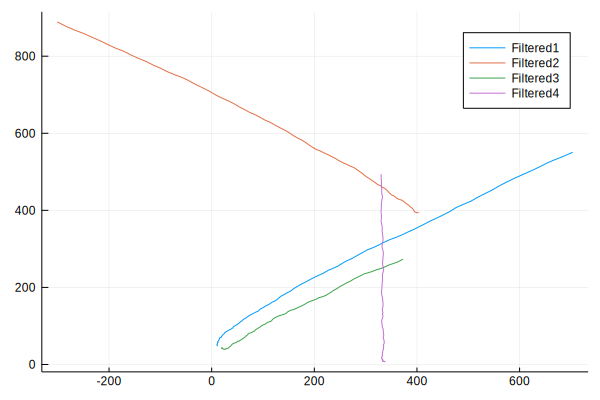

In [88]:
xf,kGains = runKalmanKinematic(measurementsNoise,dt,.1,.1,-.1,.1,.05,.05,0,.1,noise/2,vnoise/2)
plot(xf[1,1,:],xf[2,1,:],label="Filtered1")
plot!(xf[1,2,:],xf[2,2,:],label="Filtered2")
plot!(xf[1,3,:],xf[2,3,:],label="Filtered3")
plot!(xf[1,4,:],xf[2,4,:],label="Filtered4")

RMSE error of filtered values. X, Y, Vx, Vy in order

In [89]:
sqrt.(sum((xf - (measurementsTrue)).^2,dims=3)/100)

4×4×1 Array{Float64,3}:
[:, :, 1] =
 3.87878   2.64443   2.42867   1.86085 
 4.70027   4.13546   4.57075   2.87102 
 0.361682  0.423594  0.377192  0.372261
 0.411334  0.396173  0.325737  0.406712